In [1]:
from glob import glob
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
!pip install opencv-python #EN ALGUNOS CASOS SE DEBE REINSTALAR LA LIBBRERIA OPENCV YA QUE EL SIFT PUEDE FALLAR CON VERSIONES ANTERIORES

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/computer-vision-um/cv-um-2022/trabajo-final/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/computer-vision-um/cv-um-2022/trabajo-final


In [4]:
def calculate_distance(vector_1, vector_2):
  return np.linalg.norm(vector_1 - vector_2)

In [5]:
def find_pairs(vector_set_1, vector_set_2):
    vector_1_indexes = []
    vector_2_indexes = []
    point_index = -1
  
    for index_v1, value_v1 in enumerate(vector_set_1):
        min_distance = np.inf
        for index_v2, value_v2 in enumerate(vector_set_2):

            distance = calculate_distance(vector_set_1[index_v1], vector_set_2[index_v2])
            if distance < min_distance:
                min_distance = distance
                point_index = index_v2
        vector_1_indexes.append(point_index)

    for index_v2, value_v2 in enumerate(vector_set_2):
        min_distance = np.inf
        for index_v1, value_v1 in enumerate(vector_set_1):
            distance = calculate_distance(vector_set_2[index_v2], vector_set_1[index_v1])
            if distance < min_distance:
                min_distance = distance
                point_index = index_v1
        vector_2_indexes.append(point_index)

    return [(index, value) for index, value in enumerate(vector_1_indexes) if index == vector_2_indexes[value]]

In [6]:
def filter_threshold(indexes, descriptor_set_1, descriptor_set_2, threshold):
    return [(index[0], index[1]) for index in indexes if (calculate_distance(descriptor_set_1[index[0]], descriptor_set_2[index[1]])) < threshold]

In [7]:
def generate_matrix(homograph_values, kp_2, kp_1):
    xi = [t[0][0] for t in homograph_values]
    yi = [t[0][1] for t in homograph_values]

    kp1h = [kp_1[i] for i in xi]
    kp2h = [kp_2[i] for i in yi]

    x1 = [t.pt[0] for t in kp1h]
    y1 = [t.pt[1] for t in kp1h]

    x = [t.pt[0] for t in kp2h]
    y = [t.pt[1] for t in kp2h]

    P = np.array([
            [-x[0], -y[0], -1, 0, 0, 0, x[0] * x1[0], y[0] * x1[0], x1[0]],
              [0, 0, 0, -x[0], -y[0], -1, x[0] * y1[0], y[0] * y1[0], y1[0]],
              [-x[1], -y[1], -1, 0, 0, 0, x[1] * x1[1], y[1] * x1[1], x1[1]],
              [0, 0, 0, -x[1], -y[1], -1, x[1] * y1[1], y[1] * y1[1], y1[1]],
              [-x[2], -y[2], -1, 0, 0, 0, x[2] * x1[2], y[2] * x1[2], x1[2]],
              [0, 0, 0, -x[2], -y[2], -1, x[2] * y1[2], y[2] * y1[2], y1[2]],
              [-x[3], -y[3], -1, 0, 0, 0, x[3] * x1[3], y[3] * x1[3], x1[3]],
              [0, 0, 0, -x[3], -y[3], -1, x[3] * y1[3], y[3] * y1[3], y1[3]],
              [0, 0, 0, 0, 0, 0, 0, 0, 1]])

    b = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1])
    Pt = np.transpose(P)
    PtP = np.dot(Pt, P)
    inversa = np.linalg.inv(PtP)
    Ptb = np.dot(Pt, b)
    h = np.dot(inversa, Ptb)

    H = np.array([[h[0], h[1], h[2]], [h[3], h[4], h[5]], [h[6], h[7], h[8]]])

    return H

In [8]:
def ransac(indexes, kp_2, kp_1, num_of_iterations,size,threshold_distance):
    
    
    points_1 = np.float32([kp_1[i[0]].pt for i in indexes])
    points_2 = np.float32([kp_2[i[1]].pt for i in indexes])

    point1_hold = []
    point2_hold = []

    best_result=0
    
    for i in range(num_of_iterations):
        index = np.random.randint(0, len(indexes), size)
        homograph_values = [(indexes[t], 1) for t in index]
        try:
            transform_matrix_tmp = generate_matrix(homograph_values, kp_2, kp_1)
        except:
            continue
        point2_transformed = [np.dot(transform_matrix_tmp, np.append(point, 1)) for point in points_2]
        point2_transformed=[np.array([i[0] / i[2], i[1] / i[2]]) for i in point2_transformed]

        distances=np.sqrt(np.sum((point2_transformed-points_1)**2,axis=1))
        num_inliers = distances[distances < threshold_distance].shape[0]
        
        if num_inliers==0:
          continue

        if i ==0:
          best_result = num_inliers
          index_inliers = np.argwhere(distances < threshold_distance).flatten()
    
        if  best_result < num_inliers:
            best_result = num_inliers
            index_inliers = np.argwhere(distances < threshold_distance).flatten()
            homograph_values = [(indexes[k], 1) for k in index]
            transform_matrix = generate_matrix(homograph_values, kp_2, kp_1)
    return transform_matrix

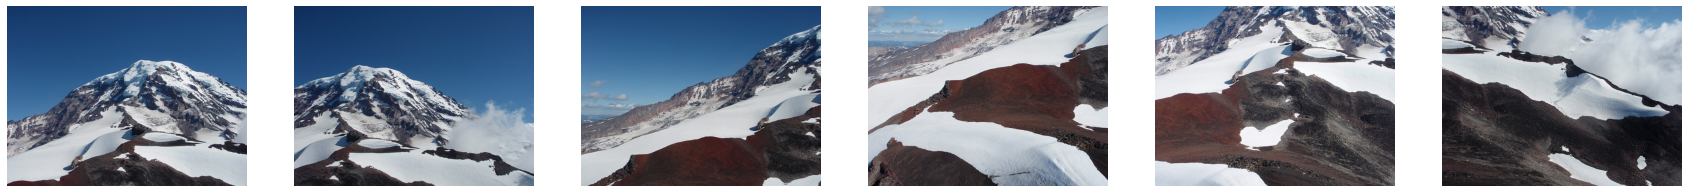

In [9]:
image_file_list = sorted(glob(os.path.join('images/', 'Rainier*')))
image_list = [cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB) for image_file in image_file_list]
fig, axs = plt.subplots(1, 6, figsize=(30, 8))
for ax, img in zip(axs, image_list):
    ax.imshow(img)
    ax.axis('off')

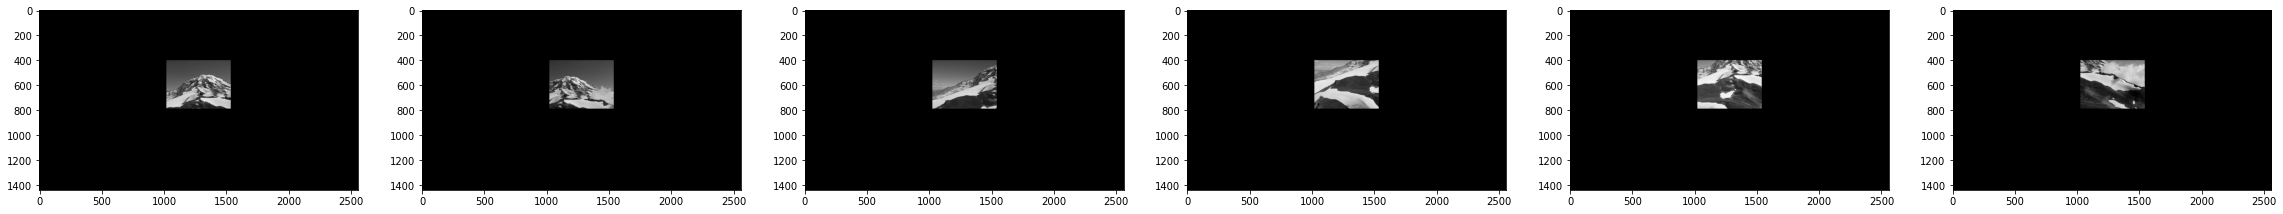

In [10]:
image_list = []
plt.figure(figsize=(40, 20))
for count, image in enumerate(image_file_list, 1):
    tmp_image = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    img_aux = np.zeros((1440, 2560), dtype=np.uint8)
    img_aux[img_aux.shape[0] // 2 -125- tmp_image.shape[0] // 2:img_aux.shape[0] // 2 -125+ tmp_image.shape[0] // 2,
    img_aux.shape[1] // 2 - tmp_image.shape[1] // 2:img_aux.shape[1] // 2 + 1 + tmp_image.shape[1] // 2] = tmp_image
    tmp_image = img_aux
    plt.subplot(1, 6, count)
    plt.imshow(tmp_image, cmap='gray')
    image_list.append(tmp_image)
plt.show()

In [11]:
detector = cv2.SIFT_create()

kp,des=detector.detectAndCompute(image_list[4],None)
key_points_and_descriptors = [detector.detectAndCompute(image, None) for image in image_list]
indexes_2_1 = filter_threshold(find_pairs(key_points_and_descriptors[0][1], key_points_and_descriptors[1][1]), key_points_and_descriptors[0][1], key_points_and_descriptors[1][1], 50)
indexes_3_1 = filter_threshold(find_pairs(key_points_and_descriptors[0][1], key_points_and_descriptors[2][1]), key_points_and_descriptors[0][1], key_points_and_descriptors[2][1], 50)
indexes_4_3 = filter_threshold(find_pairs(key_points_and_descriptors[2][1], key_points_and_descriptors[3][1]), key_points_and_descriptors[2][1], key_points_and_descriptors[3][1], 50)
indexes_5_1 = filter_threshold(find_pairs(key_points_and_descriptors[0][1], key_points_and_descriptors[4][1]), key_points_and_descriptors[0][1], key_points_and_descriptors[4][1], 50)
indexes_6_2 = filter_threshold(find_pairs(key_points_and_descriptors[1][1], key_points_and_descriptors[5][1]), key_points_and_descriptors[1][1], key_points_and_descriptors[5][1], 50)


In [12]:
m1 = ransac(indexes_2_1, key_points_and_descriptors[1][0], key_points_and_descriptors[0][0], 1000, 4, 0.05)
m2 = ransac(indexes_3_1, key_points_and_descriptors[2][0], key_points_and_descriptors[0][0], 1000, 4, 0.05)
m3 = ransac(indexes_4_3, key_points_and_descriptors[3][0], key_points_and_descriptors[2][0], 1000, 4, 0.05)
m4 = ransac(indexes_5_1, key_points_and_descriptors[4][0], key_points_and_descriptors[0][0], 1000, 4, 0.05)
m5 = ransac(indexes_6_2, key_points_and_descriptors[5][0], key_points_and_descriptors[1][0], 1000, 4, 0.05)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


In [13]:
colored_images = []
for image in image_file_list:
    tmp_colored_image = cv2.imread(image, cv2.COLOR_BGR2RGB)
    img_aux = np.zeros((1440, 2560), dtype=np.uint8)
    img_aux = cv2.cvtColor(img_aux, cv2.COLOR_GRAY2RGB)
    img_aux[img_aux.shape[0] // 2 -125- tmp_colored_image.shape[0] // 2:img_aux.shape[0] // 2 -125+ tmp_colored_image.shape[0] // 2,
    img_aux.shape[1] // 2 - tmp_colored_image.shape[1] // 2:img_aux.shape[1] // 2 + 1 + tmp_colored_image.shape[1] // 2] = tmp_colored_image
    tmp_colored_image = img_aux
    colored_images.append(tmp_colored_image)

In [14]:
dst2 = cv2.warpPerspective(image_list[1], m1, (image_list[1].shape[1], image_list[1].shape[0]))
dst3 = cv2.warpPerspective(image_list[2], m2, (image_list[1].shape[1], image_list[1].shape[0]))
dst4 = cv2.warpPerspective(image_list[3], np.dot(m2, m3), (image_list[1].shape[1], image_list[1].shape[0]))
dst5 = cv2.warpPerspective(image_list[4], m4, (image_list[1].shape[1], image_list[1].shape[0]))
dst6 = cv2.warpPerspective(image_list[5], np.dot(m1, m5), (image_list[1].shape[1], image_list[1].shape[0]))

dst2c = cv2.warpPerspective(colored_images[1], m1, (colored_images[1].shape[1], colored_images[1].shape[0]))
dst3c = cv2.warpPerspective(colored_images[2], m2, (colored_images[1].shape[1], colored_images[1].shape[0]))
dst4c = cv2.warpPerspective(colored_images[3], np.dot(m2, m3), (colored_images[1].shape[1], colored_images[1].shape[0]))
dst5c = cv2.warpPerspective(colored_images[4], m4, (colored_images[1].shape[1], colored_images[1].shape[0]))
dst6c = cv2.warpPerspective(colored_images[5], np.dot(m1, m5), (colored_images[1].shape[1], colored_images[1].shape[0]))


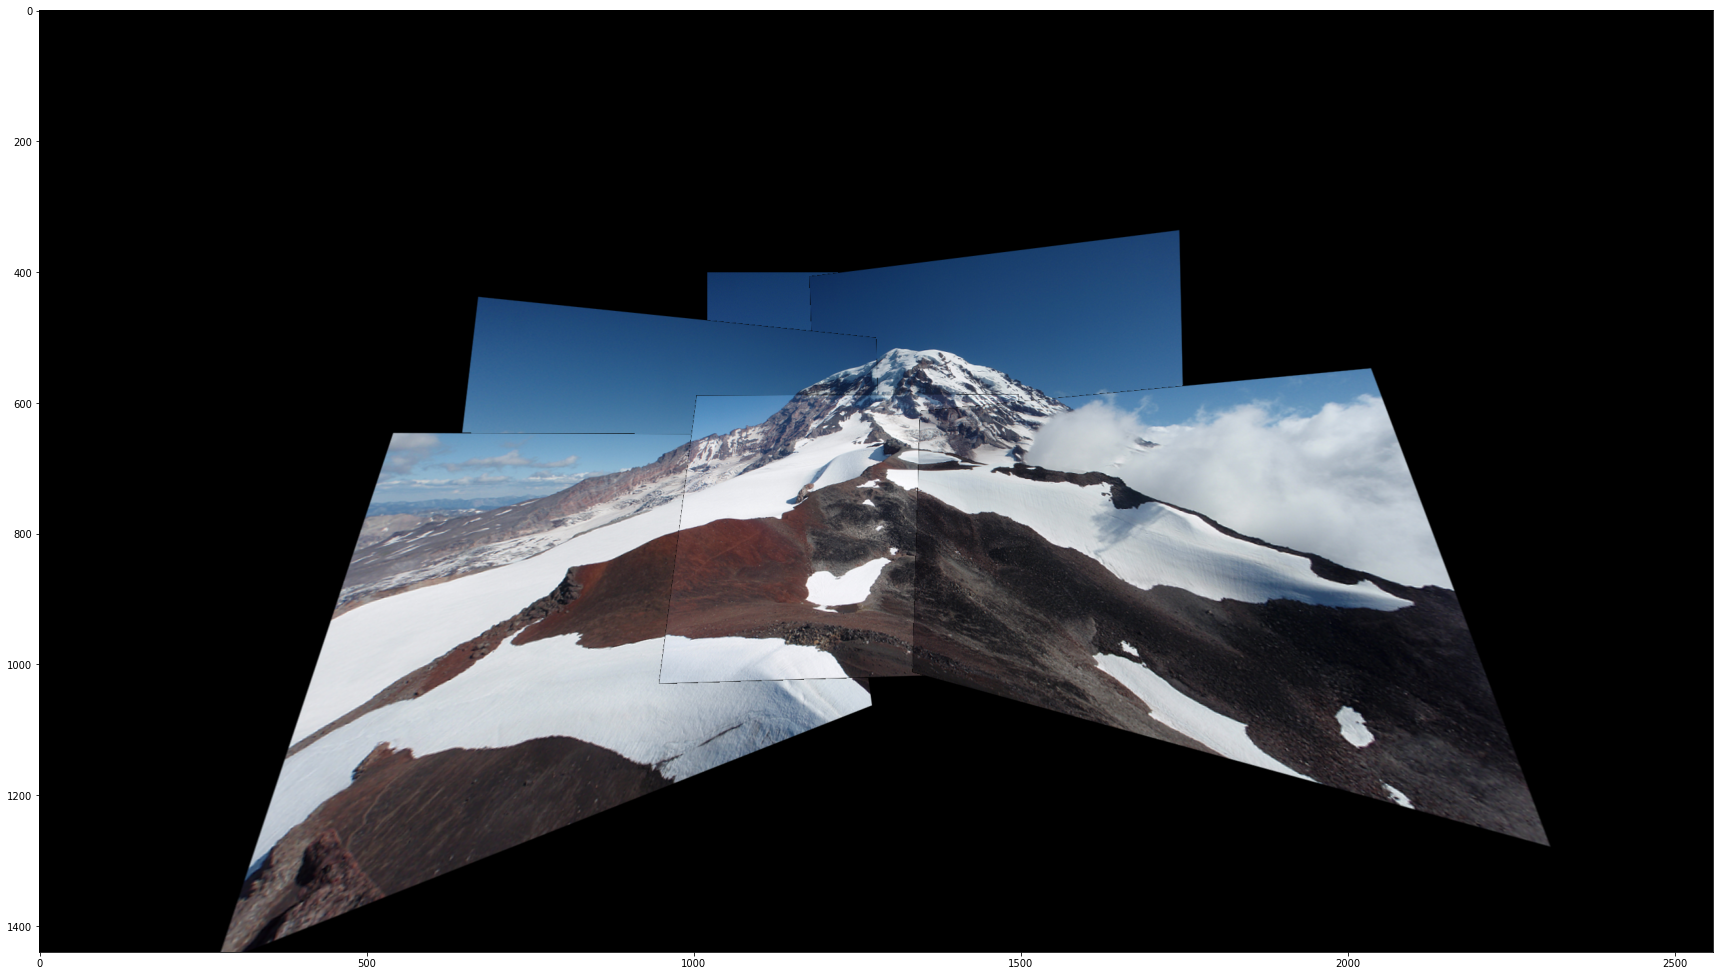

In [15]:
mask2 = ~(dst2 > 0)
mask3 = ~(dst3 > 0)
mask4 = ~(dst4 > 0)
mask5 = ~(dst5 > 0)
mask6 = ~(dst6 > 0)

masked = cv2.bitwise_and(colored_images[0], colored_images[0], mask=mask2.astype(np.uint8))
stitch = dst2c + masked

masked = cv2.bitwise_and(stitch, stitch, mask=mask3.astype(np.uint8))
stitch = dst3c + masked

masked = cv2.bitwise_and(stitch, stitch, mask=mask4.astype(np.uint8))
stitch = dst4c + masked

masked = cv2.bitwise_and(stitch, stitch, mask=mask5.astype(np.uint8))
stitch = dst5c + masked

masked = cv2.bitwise_and(stitch, stitch, mask=mask6.astype(np.uint8))
stitch = dst6c + masked

stitch = cv2.cvtColor(stitch, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(30, 30))
plt.imshow(stitch)
plt.show()